# Clustering Trajectories with the Expectation-Maximization algorithm (E-M)

First, we'll import the scientific and plotting libraries.

In [1]:
# Import required modules.
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# import auxiliar modules.
import expMax as em
import plotting as myplt
import probability as pobty
%matplotlib inline 

Load trayectory data from the 'tjcs.npy' file. <br />
A set of 1856 trajectories generated from the  <br />
"Edinburgh Informatics Forum Pedestrian Database": http://homepages.inf.ed.ac.uk/rbf/FORUMTRACKING/

In [3]:
data = np.load("data/tjcs.npy")

In [4]:
# Choose the first 500 trajectories.
tjcs = data[:500]

Let's take a look at the trajectories.

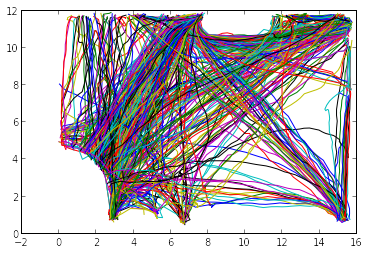

In [5]:
myplt.plot_trajectories(tjcs)

When inspecting the figure, some trajectories seem to "belong together". Finding those groups can be done with the E-M algorithm.

We have several 2D points per data sample (trajectory). Thus, a trajectory may be represented as a sequence $S_n$ of points.

$$S_n = \{p^1_n, \cdots, p^T_n\}$$

Where each point $p^t_n$ corresponds to the position of person $n$ at time $t$.

$$p^t_n = (x^t_n, y^t_n)$$

The E-M algorithm assumes that all the clusters to have the same covariance $\Sigma$, so we can represent each cluster $\theta_m$ as a sequence of two-dimensional mean values.

$$\theta_m = \{\mu^1_m, \cdots, \mu^T_m\}$$

In this way, we can initialize the cluster mean values. At this point we are going to do it by selecting trajectories at random.

In [6]:
T = tjcs.shape[1]
M = 10
N = tjcs.shape[0]

means = np.zeros( (M, T, 2) )
tjcIndex = random.sample( np.arange( N ), M )
for m, n in zip( xrange( M ), tjcIndex):
    means[m] = tjcs[n]

Let's plot the resulting means.

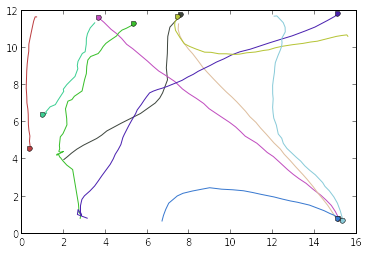

In [7]:
myplt.plot_trajectories(means)

We also compute the covariance from the trajectories data:

In [8]:
vtjcs = tjcs[0]
for i in xrange(tjcs.shape[0]):
    if i != (tjcs.shape[0] - 1):
        vtjcs = np.vstack((vtjcs, tjcs[i+1]))

covariance = np.round(np.cov(vtjcs.T)*np.eye(vtjcs.shape[1]))
print covariance

[[ 20.   0.]
 [  0.  17.]]


This are some auxiliar functions used by the E-M algorithm.

In [9]:
def t_zero( trajectory ):
    """ Set the values of a trajectory to zero."""
    trajectory *= 0.0

def t_cummulate( weight, t1, t2 ):
    """ Cummulate weighted tjc t2 into t1 """
    t1 += weight * t2
        
def t_gaussian( mean, covariance, value ):
    """ Multivariate Gaussian Probability Distribution Function (PDF) """
    inv = np.linalg.inv(covariance)
    diff = mean - value
    dist = -0.5 * np.dot(np.dot(diff, inv), diff.transpose())
    exp = np.exp(np.diagonal(dist))
    return np.multiply.reduce(exp)

# The Expectation Step
To calculate the expectations, that give us the clusters, we apply Bayes rule, obeying independence assumptions between different data trajectories. Exploiting the fact that the distributions are represented by Gaussians we obtain: <br />

$$E^n_m = \prod_{t = 1}^{T}e^{-(p^t_n - \mu^t_m) \Sigma^{-1}(p^t_n - \mu^t_m)}$$

In [10]:
def expectation(tjcs, means, covariance, gaussian):
    """Expectation step: For every trajectory calculate the Expected likehood
    that it belongs to the current cluster model given by the means array.
    """
    tjcsN = len(tjcs)                   # Number of trajectories
    cltsN = len(means)                  # Number of clusters
    clusters = np.zeros((tjcsN, cltsN)) # Expected clusters
    for n in xrange(tjcsN):
        for m in xrange(cltsN):
            # Call to Multivariate Gaussian PDF.
            clusters[n, m] = gaussian(means[m], covariance, tjcs[n])
    return clusters

# The Maximization Step
The M-step calculates a new model $\theta_m[j+1]$ by maximizing the expected likelihood. Technically, this is done by computing for every motion pattern $m$ and for each time step $t$ a new mean $\mu^t_m[j+1]$ of the Gaussian distribution.

$$u^t_m[j+1] = \frac{\sum_{i=1}^{N}E[c_{im} | \theta^j,d]x^t_i}{\sum_{i=1}^{N}E[c_{im}|\theta^j,d]}$$


In [11]:
def maximization(tjcs, clusters, means, zero, cummulate):
    """Maximization step: Calculate new cluster models that Maximizes the 
    Expected likehood.
    """
    tjcsN = len(tjcs)
    cltsN = len(means)
    for m in xrange(cltsN):
        zero(means[m])
        for n in xrange(tjcsN):
            cummulate(clusters[n, m], means[m], tjcs[n])
        means[m] /= np.sum(clusters[:, m]) # Normalize

Let's iterate once.

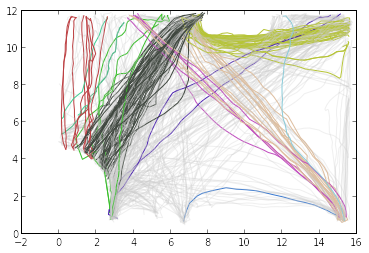

In [12]:
clusters = expectation(tjcs, means, covariance, pobty.t_gaussian)
maximization(tjcs, clusters, means, pobty.t_zero, pobty.t_cummulate)
myplt.plot_clusters(clusters, tjcs)

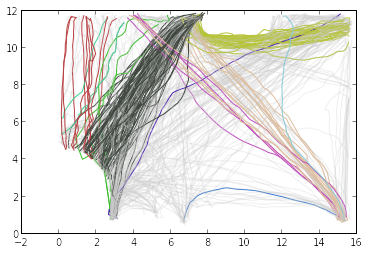

In [13]:
for i in xrange(10):
    clusters = expectation(tjcs, means, covariance, pobty.t_gaussian)
    maximization(tjcs, clusters, means, pobty.t_zero, pobty.t_cummulate)
myplt.plot_clusters(clusters, tjcs)

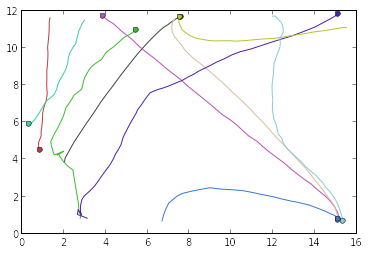

In [14]:
myplt.plot_trajectories(means)

After all those iterations, it seems that not all clusters are contributing in the same way, as shown in the following plot.

<Container object of 10 artists>

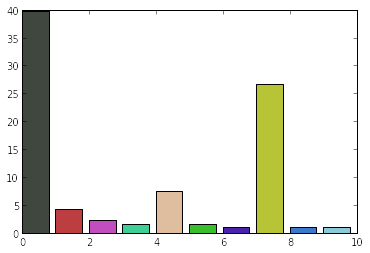

In [15]:
cluster_contribs = np.sum(clusters, 0)
plt.bar(arange(M), cluster_contribs, color = myplt.generate_palette(M))

In [16]:
def worst_cluster(clusters):
    """ Find the worst cluster: the cluster with the fewer number of
        trajectories.
    """
    M = clusters.shape[1]  # Number of Clusters.
    with_cluster = np.sum(np.max(clusters, 1)) # Sum of best cluster scores.
    cluster_scores = np.zeros((M, ))
    for m in xrange(M):
        without_cluster = clusters.copy()
        without_cluster[:, m] = 0. # Exclude current cluster.
        cluster_scores[m] = with_cluster - np.sum(np.max( without_cluster, 1))
    # The cluster that scores the less is the selected one.    
    index = np.argmin(cluster_scores)
    score = np.min(cluster_scores)
    return index, score


def worst_trajectory(clusters, c_index, c_score, visited, tjcs, covariance):
    """ Find the worst trajectory: For the worst trajectory, we iterate with 
    individual trajectory scores, replacing them with the worst cluster and 
    looking for a positive increase in the score. 
    """
    N = tjcs.shape[0]      # Number of Trajectories.
    M = clusters.shape[1]  # Number of Clusters.
    
    # Sort trajectories by contribution.
    traj_contribs = np.sum(clusters, 1)
    traj_contribs[visited] = 1E6 # Ignore trajectories already visited.
    sorted_trajs = np.argsort(traj_contribs)
    
    # Find worst trajectory. If its score is bigger than the worst cluster one,
    # return its score and index.
    tmp_cluster = clusters.copy()
    tmp_cluster[:, c_index] = 0.0
    without_cluster = np.sum(np.max(clusters, 1)) 
    for k in sorted_trajs:
        for n in xrange( N ):
            # Call to Multivariate Gaussian PDF.
            tmp_cluster[n, c_index] = pobty.t_gaussian(tjcs[k], covariance, tjcs[n])
        t_score = np.sum(np.max(tmp_cluster, 1)) - without_cluster
        if t_score > c_score:
            return k, t_score
    return -1, 0.0

Replacing cluster 9 with trajectory 410
Replacing cluster 8 with trajectory 215
Replacing cluster 6 with trajectory 221
Replacing cluster 3 with trajectory 343
Replacing cluster 5 with trajectory 398
Replacing cluster 2 with trajectory 151
Replacing cluster 9 with trajectory 142
Replacing cluster 6 with trajectory 242
Replacing cluster 3 with trajectory 104
Replacing cluster 1 with trajectory 137
Replacing cluster 5 with trajectory 252
Replacing cluster 3 with trajectory 125
Replacing cluster 3 with trajectory 477
Replacing cluster 3 with trajectory 235
Replacing cluster 5 with trajectory 415
Replacing cluster 5 with trajectory 284
Replacing cluster 5 with trajectory 149
Replacing cluster 3 with trajectory 481


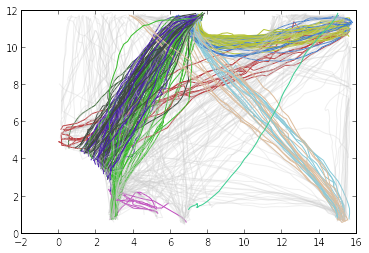

In [17]:
iterations = 20
for i in xrange(iterations):
    # Each iteration, The E-M algorithm is run five times.
    for j in xrange(5):
        clusters = expectation(tjcs, means, covariance, pobty.t_gaussian)
        maximization(tjcs, clusters, means, pobty.t_zero, pobty.t_cummulate)
    
    # Replace the worst cluster with the worst represented trajectory 
    # to improve the quality of the clusters.    
    if i < iterations - 1:
        c_index, c_score = worst_cluster(clusters)
        t_index, t_score = worst_trajectory(clusters, c_index, c_score, tjcIndex, tjcs, covariance)
        # If a worst trajectory is not found.
        if t_index == -1:
            #break
            means[c_index] = -1
        else:    
            print "Replacing cluster %i with trajectory %i" % ( c_index, t_index )
            means[c_index] = tjcs[t_index]
            tjcIndex.append( t_index )
myplt.plot_clusters(clusters, tjcs)

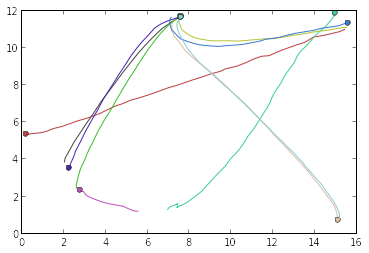

In [18]:
myplt.plot_trajectories(means)
np.save("data/clusters.npy", means)

<Container object of 10 artists>

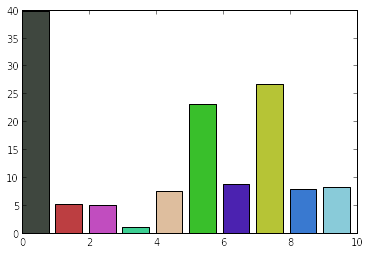

In [19]:
cluster_contribs = np.sum(clusters, 0)
plt.bar(arange(M), cluster_contribs, color = myplt.generate_palette(M))